---
## Import package

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

import math

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
cph = CoxPHFitter()
kmf = KaplanMeierFitter()
from lifelines.statistics import logrank_test
from lifelines import utils

---
## Import data
* target.csv 파일을 불러옵니다.
* column name: Survival Status, Overall Survival, gene1, gene2...

In [3]:
km_target = pd.read_csv('./target.csv')

In [4]:
km_target.head()

,Survival Status,Overall Survival,CLCF1,MIR181A2HG
0,1,15.18,6.746384,1.017896
1,1,9.30,8.085704,1.538286
2,1,26.48,8.285810,0.393159
3,0,23.72,5.969038,0.167099
4,1,57.88,5.163165,0.269058


---
## Survival analysis
* optimal p-value를 기준으로 cutoff를 결정합니다.
* survival_gene1.png, survival_gene2.png... 이름으로 저장됩니다.

0.04120443159839079 1
0.031191835789303186 57
0.023146714309648885 58
0.018672136678871288 63
0.009556970938621876 64
0.5795200376994746 1
0.3201789008400774 5
0.1125129994456594 6
0.10606768621515034 8
0.09617335318120002 10
0.051937541470485266 43
0.04320902317300304 45
0.02941701861238142 61
0.02885001707158305 63
0.01596715238366774 64
0.01555477647662378 65
0.011166469340575469 66


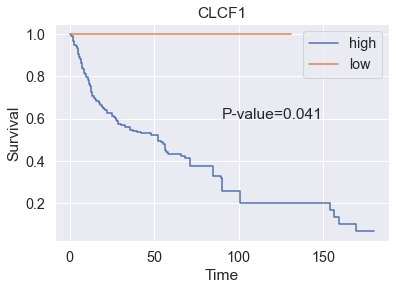

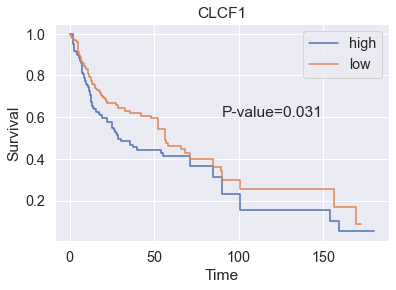

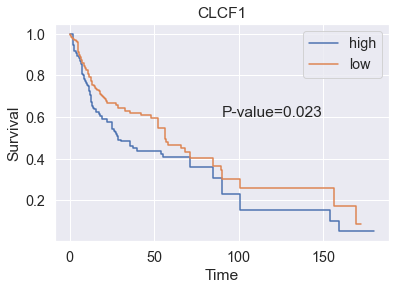

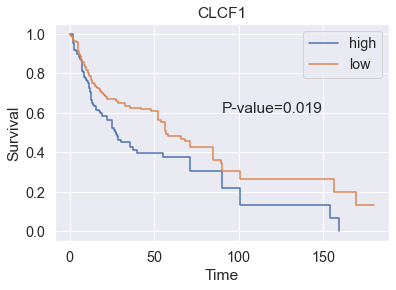

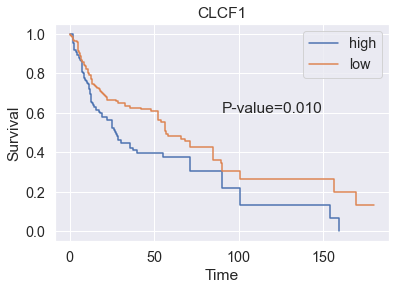

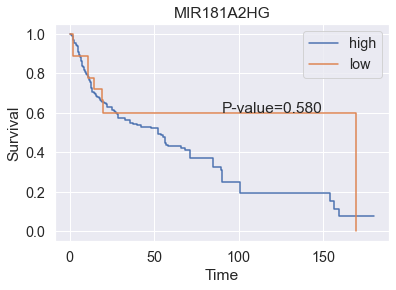

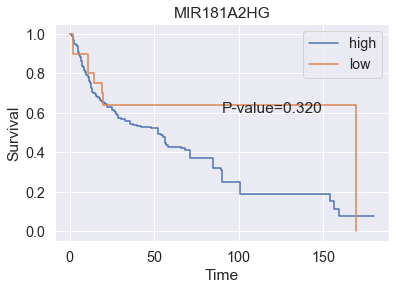

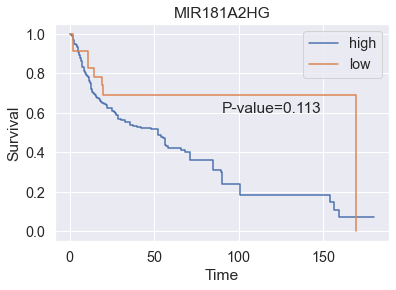

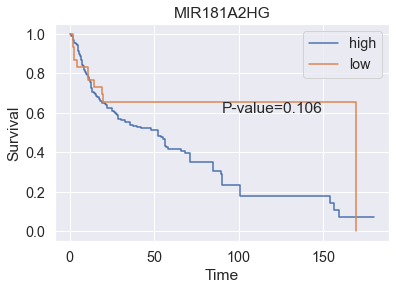

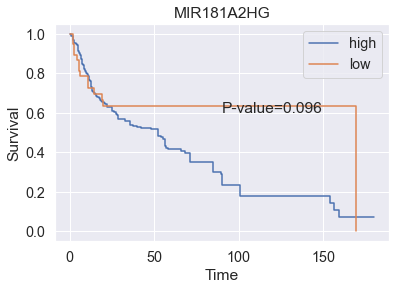

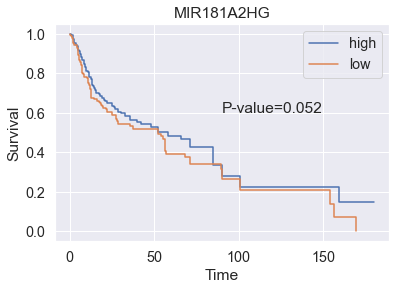

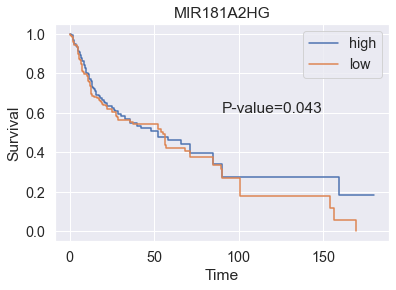

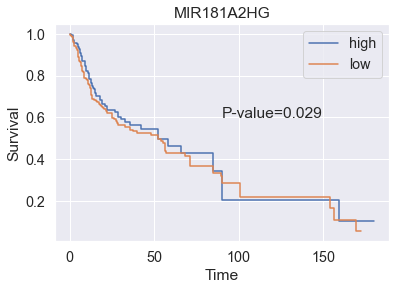

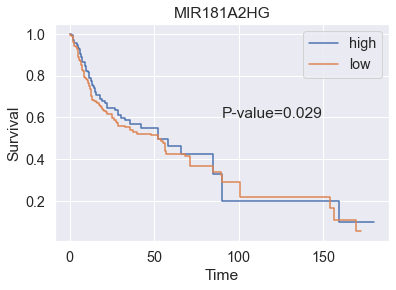

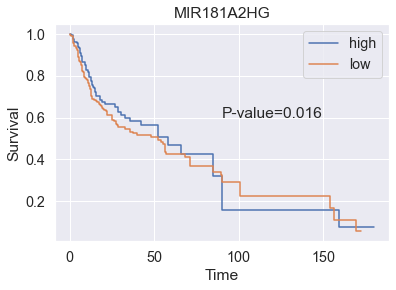

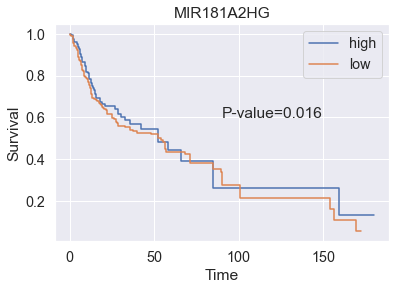

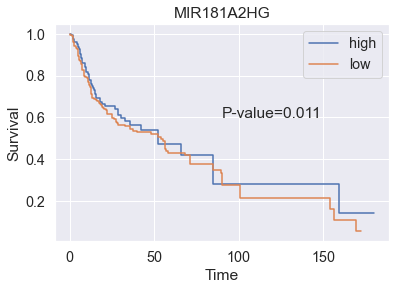

In [5]:
opt_scores = []
percents = []

for i in (km_target.columns[2:]):
    
    opt_score = 1
    percent = 0

    km_target2 = km_target[['Survival Status','Overall Survival',i]].copy()
    
    for j in range(1,100):
        mask = km_target2[i] > km_target2[i].quantile(j/100, interpolation='midpoint')
        
        result = logrank_test(km_target2['Survival Status'][mask], km_target2['Survival Status'][-mask], 
                              km_target2['Overall Survival'][mask], km_target2['Overall Survival'][-mask], alpha=.99)
        pvalue = result.p_value        

        if opt_score > pvalue:
            opt_score = pvalue
            percent = j
            
            print(opt_score, percent)
            
            kmf.fit(km_target2['Overall Survival'][mask], km_target2['Survival Status'][mask], label='high')
            ax = kmf.plot(ci_show=False)

            kmf.fit(km_target2['Overall Survival'][-mask], km_target2['Survival Status'][-mask], label='low')
            kmf.plot(ax=ax, ci_show=False)
            
            ax.text(90,0.6,'P-value=%.3f'% pvalue)

            ax.set_xlabel('Time')
            ax.set_ylabel('Survival')
            ax.set_title('%s' %i)
            plt.savefig('./survival_%s.png' %i, dpi=300, bbox_inches='tight')
                
    opt_scores.append(opt_score)
    percents.append(percent)

---
## CoxPH
* optimal p-value를 이용한 survival analysis를 먼저 실행하세요.
* cox.csv 파일로 결과가 저장되며, cox_forest_plot.png 파일로 그래프가 저장됩니다.

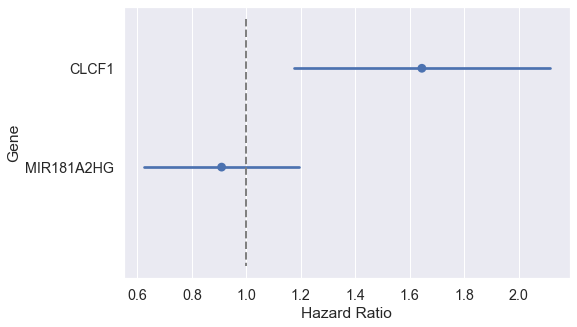

In [6]:
km_target2 = km_target.copy()

for i in range(2,len(km_target.columns)):
    km_target2.iloc[:,i] = km_target2.iloc[:,i] > km_target2.iloc[:,i].quantile(percents[i-2]/100, interpolation='midpoint')

cph.fit(km_target2, duration_col='Overall Survival', event_col='Survival Status')

coxplot = cph.summary

coxplot.to_csv('./cox.csv')

#for seaborn pointplot
coxplot2 = coxplot.loc[:,['upper 0.95']]
coxplot2.columns = ['lower 0.95']
coxplot = coxplot.append(coxplot2)

coxplot['lower 0.95'] = coxplot['lower 0.95'].apply(math.exp)

plt.figure(figsize=(8,5))
ax = sns.pointplot(x="lower 0.95", y=coxplot.index, data=coxplot, join=False)
plt.plot([1, 1], [-0.5, coxplot.shape[0]/2], color='grey', linestyle='dashed', lw=2)
plt.ylabel('Gene')
plt.xlabel('Hazard Ratio')
#plt.xlim(0,2)
plt.savefig('./cox_forest_plot.png', dpi=300, bbox_inches='tight')

---
## Survival analysis
* 5-fold CV를 이용한 optimal C-index를 기준으로 cutoff를 결정합니다.
* survival_gene1.png, survival_gene2.png... 이름으로 저장됩니다.

C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:925: ConvergenceWarning: Column CLCF1 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Survival Status'].astype(bool)
>>> print(df.loc[events, 'CLCF1'].var())
>>> print(df.loc[~events, 'CLCF1'].var())

A very low variance means that the column CLCF1 completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)
C:\Users\bioinfo205_01\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:554: ConvergenceWarning: Newton-Rhapson convergence completed but norm(delta) is still high, 0.101. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in t

0.5108138704909856 2
0.517511465236206 5
0.5176750421173401 6
0.5185378075021531 10
0.5266937100290991 11
0.5311645041638037 12
0.531253713411904 17
0.5330633471983512 18
0.5003972426388695 9
0.5267966910265448 12


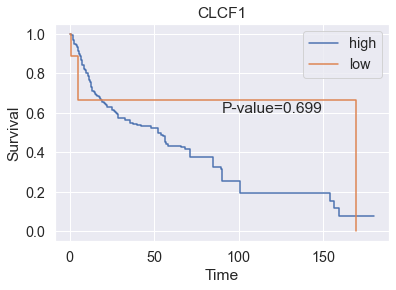

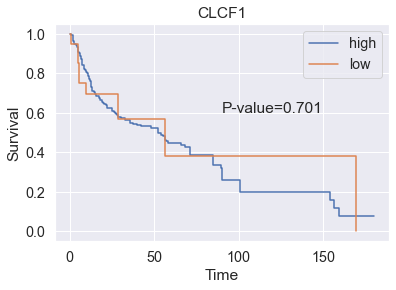

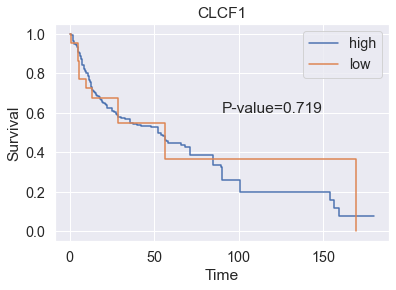

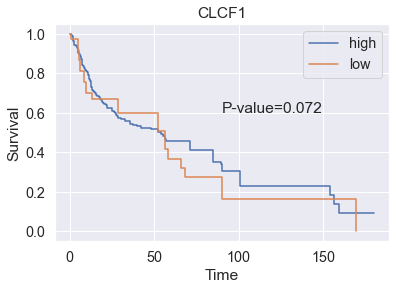

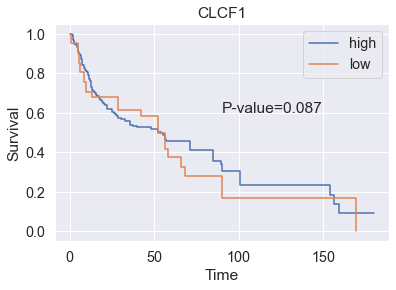

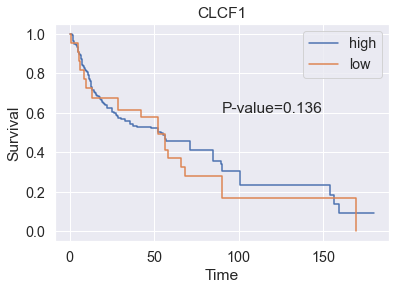

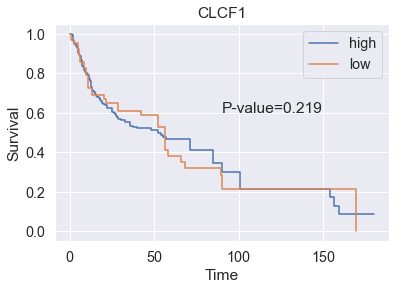

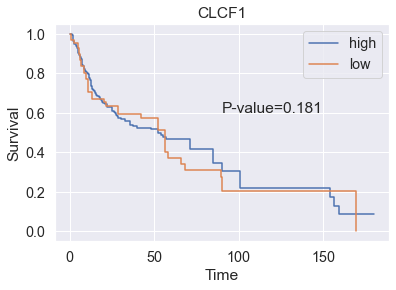

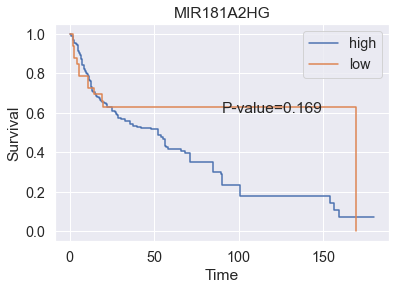

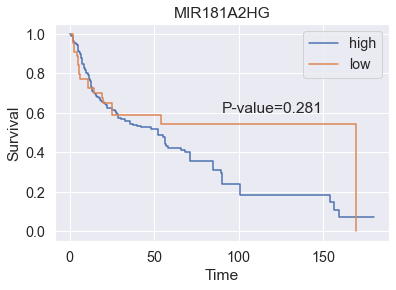

In [7]:
opt_scores = []
percents = []

for i in (km_target.columns[2:]):
    
    opt_score = 0.5
    percent = 0

    for j in range(1,100):
        km_target2 = km_target[['Survival Status','Overall Survival',i]].copy()
        km_target2[i] = km_target2[i] > km_target[i].quantile(j/100, interpolation='midpoint')        

        if(len(km_target2[i].unique()) == 2):
            try:
                np.random.seed(12345)
                scores = utils.k_fold_cross_validation(cph, km_target2,
                                                 duration_col='Overall Survival',
                                                 event_col='Survival Status', k=5,
                                                 predictor='predict_partial_hazard')
            except:
                pass

            if opt_score < np.mean(scores):
                opt_score = np.mean(scores)
                percent = j
                
                print(opt_score, percent)
                
                result = logrank_test(km_target2['Survival Status'][km_target2[i]], km_target2['Survival Status'][-km_target2[i]], 
                                      km_target2['Overall Survival'][km_target2[i]], km_target2['Overall Survival'][-km_target2[i]], alpha=.99)
                pvalue = result.p_value

                kmf.fit(km_target2['Overall Survival'][km_target2[i]], km_target2['Survival Status'][km_target2[i]], label='high')
                ax = kmf.plot(ci_show=False)

                kmf.fit(km_target2['Overall Survival'][-km_target2[i]], km_target2['Survival Status'][-km_target2[i]], label='low')
                kmf.plot(ax=ax, ci_show=False)

                ax.text(90,0.6,'P-value=%.3f'% pvalue)

                ax.set_xlabel('Time')
                ax.set_ylabel('Survival')
                ax.set_title('%s' %i)
                plt.savefig('./survival_%s.png' %i, dpi=300, bbox_inches='tight')
                
    opt_scores.append(opt_score)
    percents.append(percent)

---
## CoxPH
* 5-fold CV를 이용한 survival analysis를 먼저 실행하세요.
* cox.csv 파일로 결과가 저장되며, cox_forest_plot.png 파일로 그래프가 저장됩니다.

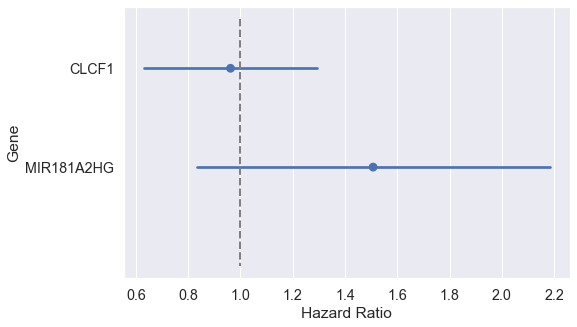

In [8]:
km_target2 = km_target.copy()

for i in range(2,len(km_target.columns)):
    km_target2.iloc[:,i] = km_target2.iloc[:,i] > km_target2.iloc[:,i].quantile(percents[i-2]/100, interpolation='midpoint')

cph.fit(km_target2, duration_col='Overall Survival', event_col='Survival Status')

coxplot = cph.summary

coxplot.to_csv('./cox.csv')

#for seaborn pointplot
coxplot2 = coxplot.loc[:,['upper 0.95']]
coxplot2.columns = ['lower 0.95']
coxplot = coxplot.append(coxplot2)

coxplot['lower 0.95'] = coxplot['lower 0.95'].apply(math.exp)

plt.figure(figsize=(8,5))
ax = sns.pointplot(x="lower 0.95", y=coxplot.index, data=coxplot, join=False)
plt.plot([1, 1], [-0.5, coxplot.shape[0]/2], color='grey', linestyle='dashed', lw=2)
plt.ylabel('Gene')
plt.xlabel('Hazard Ratio')
#plt.xlim(0,2)
plt.savefig('./cox_forest_plot.png', dpi=300, bbox_inches='tight')